# Set up Google Colab

This means mounting drive and importing

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Lab/Grain-U-Net'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.

# %cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME
#!pip install

Mounted at /content/drive
/content/drive/My Drive/Lab/Grain-U-Net


In [1]:
# from Model import *
from src import unet
import data
import importlib
importlib.reload(unet)
importlib.reload(data)

<module 'data' from '/Users/jamie/Documents/Lab/graingrowth/grain-unet/data.py'>

# Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [ ]:
import keras
from skimage import io
import numpy as np

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.00,
                    height_shift_range=0.00,
                    shear_range=0.00,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
save_to_dir = 'data/train/aug'
myGene = data.trainGenerator(4,'data/train','image','label',data_gen_args, save_to_dir = save_to_dir, target_size = (256, 256))

model = Model.unet(input_size = (256, 256, 1))
model_checkpoint = keras.callbacks.ModelCheckpoint('unet_grain.hdf5', monitor='loss',verbose=1, save_best_only=False)
model.fit_generator(myGene, steps_per_epoch=50, epochs=3, callbacks=[model_checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Epoch 1/3
50/50 [==============================] - ETA: 0s - loss: 0.1360 - mae: 0.1532
Epoch 00001: saving model to unet_grain.hdf5
50/50 [==============================] - 218s 4s/step - loss: 0.1360 - mae: 0.1532
Epoch 2/3
50/50 [==============================] - ETA: 0s - loss: 0.0815 - mae: 0.1217
Epoch 00002: saving model to unet_grain.hdf5
50/50 [==============================] - 205s 4s/step - loss: 0.0815 - mae: 0.1217
Epoch 3/3
38/50 [=====================>........] - ETA: 49s - loss: 0.0819 - mae: 0.1201

### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### Investigate Filters

In [ ]:
# lil snippet to try to view the filters
import numpy as np
from skimage import io
model = Model.unet()
model.load_weights("unet_grain.hdf5")
weights = model.get_weights()
filters = np.array(weights[0])

for i in range(64):
    filt = np.zeros((3,3))
    filt[0,0] = filters[0][0][0][i]
    filt[0,1] = filters[0][1][0][i]
    filt[0,2] = filters[0][2][0][i]

    filt[1,0] = filters[1][0][0][i]
    filt[1,1] = filters[1][1][0][i]
    filt[1,2] = filters[1][2][0][i]
    
    filt[2,0] = filters[2][0][0][i]
    filt[2,1] = filters[2][1][0][i]
    filt[2,2] = filters[2][2][0][i]

    io.imshow(filt)
    io.show()

### test your model and save predicted results

Loading the weights took 0.16170001029968262 seconds
Took 7.869845151901245 seconds
255.0 128.74706
(1, 720, 720, 1) 255.0 128.74706


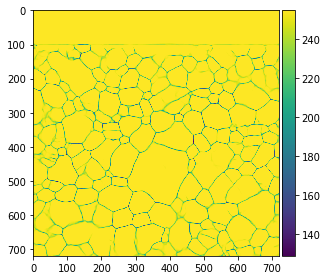

In [11]:
from tensorflow.keras.preprocessing.image import load_img
import os
from time import time

def test_img(test_dir,test_paths,num_image = 30,target_size = (256, 256),flag_multi_class = False,as_gray = True,crop = None):
    img_stack = np.zeros((num_image,) + target_size)
    for ind, image_name in enumerate(test_paths):
        img = load_img(test_dir + image_name, target_size=target_size, color_mode='grayscale')
        if crop is not None:
            print('Cropping...')
            target_size_crop = 2 * [0]
            target_size_crop[0] = int(crop[0]/crop[2] * target_size[0])
            target_size_crop[1] = int(crop[1]/crop[3] * target_size[1])
            target_size_crop = tuple(target_size_crop)
            img_arr = keras.preprocessing.image.img_to_array(img)
            img_arr = img_arr[:target_size[0], :target_size[1]]
            img = keras.preprocessing.image.array_to_img(img_arr)

        img_stack[ind] = img / (np.max(img))
        
        if ind >= num_image - 1:
            break

    return img_stack

from skimage import io
import numpy as np
import data

test_dir = 'data/test/'
test_dir_names = np.sort(os.listdir(test_dir))
is_img = np.char.find(test_dir_names, '.png')
isnt_test = np.char.find(test_dir_names, '_')
test_names = test_dir_names[np.logical_and([is_img != -1], [isnt_test == -1])[0]]

test_n = test_names.shape[0]
#testGene = data.testGenerator("data/test", target_size=(256,256))
#results = 255 * model.predict_generator(testGene, 23, verbose=1)
# results = 255 * model.predict(testGene, 23)

test_set = test_img(test_dir, test_names, num_image = test_n, target_size=(720, 720))

start = time()
model = unet.unet(input_size=(720, 720, 1))
model.load_weights("results/299_data4_nouveaux_unet_grain.hdf5")
end = time()

print(f"Loading the weights and initializing unet took {end-start} seconds")
start = time()
results = 255 * model.predict(test_set, test_n)
end = time()
print(f"Took {end-start} seconds")
print(np.max(results), np.min(results))
data.saveResult(test_dir, results.astype('uint8'))
print(results.shape, np.max(results), np.min(results))
io.imshow(results[test_n - 1, :, :, 0])

# Small Post Processing Stage

This next thing is just to visualize what the processing is doing before applying it to all the images

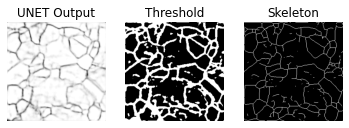

In [72]:
from skimage import data, io, filters, morphology
import numpy as np
import matplotlib.pyplot as plt

def imsubplot(ax, im, cmap="gray", title=None):
    ax.imshow(im, cmap=cmap)
    ax.axis("off")
    if title:
        ax.set_title(title)

def post_process(path, thresh=255, verbose=False):
    image = io.imread(path)
    threshold = np.zeros(image.shape)
    threshold[image < thresh] = 1
    skeleton = morphology.skeletonize(threshold)
    
    if verbose:
        fig, (a, b, c) = plt.subplots(ncols=3)
        
        imsubplot(a, image, title='UNET Output')
        imsubplot(b, threshold, title='Threshold')
        imsubplot(c, skeleton, title='Skeleton')
        plt.show()
    else:
        return skeleton

post_process('data/testerino/0_predict.png', thresh=250, verbose=True)

#### This is to apply this processing to all the boundaries

In [77]:
if 'test_n' not in locals():
    test_n = 29
    test_dir = 'data/test/'

for i in range(test_n):
    im_path = f'{test_dir}{i}_predict.png'
    skel = 255 * post_process(im_path, thresh=250)
    io.imsave(f'{test_dir}{i}_processed.png', skel.astype('uint8')) 

# Overlay 

In [80]:
from skimage import io, transform
import numpy as np
import os

if 'test_n' not in locals():
    test_n = 1
    test_dir = 'data/test/'

for i in range(test_n):
    i = i + 1
    raw_img = io.imread(f'{test_dir}0{i}.png')
    sk_img = io.imread(f'{test_dir}{i}_processed.png')
    sk_img = 255 * transform.resize(sk_img, raw_img.shape, anti_aliasing=False)
    fusion_img = np.zeros((raw_img.shape[0], raw_img.shape[1], 3), dtype=int)
    fusion_img[:, :, 0] = raw_img
    fusion_img[:, :, 1] = raw_img
    fusion_img[:, :, 2] = raw_img
    fusion_img[sk_img > 0, 0] = 255
    if os.path.isfile(f'{test_dir}key/{i}.png'):
        ht_img = io.imread(f'{test_dir}key/{i}.png')
        ht_img = 255 - (255 * transform.resize(ht_img, raw_img.shape, anti_aliasing=False))
        fusion_img[ht_img > 0, 1] = 255
#        io.imshow(fusion_img)
#        io.show()

    io.imsave(f'{test_dir}{i}_overlaid.png', fusion_img.astype('uint8')) 


FileNotFoundError: ignored

# Chi2

In [ ]:
from chi2test import find_chi2
from skimage import io, transform
import os
import numpy as np
import time

test_dir = 'data/test/'
traced_dir = 'data/test/key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

chi2_dtype = [('img', (np.str_, 10)), ('chi2', np.float64), ('avg_chi2', np.float64)]
results = np.array([], dtype=chi2_dtype)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png')
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)

    if np.min(key_img) != 0 or np.max(key_img) != 255:
        key_img -= np.min(key_img)
        key_img = np.round(key_img * (255 / np.max(key_img)))
    key_img = np.max(key_img) - key_img
    
    result = find_chi2(ml_img, key_img, out_dict=True)
    results = np.append(results, \
                np.array([(key, result["chi2"], result["avg_chi2"])], dtype=chi2_dtype))
    print(f'- img: {key} \t chi2: {result["chi2"]} \t avg_chi2: {result["avg_chi2"]} \t median_r2: {result["median_r2"]}')

print(f'\nAverage chi2: {np.mean(results["chi2"])}\nAverage avg_chi2: {np.mean(results["avg_chi2"])}\nMedian chi2: {np.median(results["chi2"])}')
print(f'Max chi2: {np.max(results["chi2"])}\nMin chi2: {np.min(results["chi2"])}')

- img: 0 	 chi2: 60429.0 	 avg_chi2: 23.449359720605354 	 median_r2: 0.0
- img: 1 	 chi2: 23919.0 	 avg_chi2: 7.671263630532392 	 median_r2: 0.0
- img: 10 	 chi2: 135697.0 	 avg_chi2: 40.53076463560335 	 median_r2: 0.0
- img: 11 	 chi2: 287719.0 	 avg_chi2: 107.67926646706587 	 median_r2: 0.0
- img: 12 	 chi2: 148700.0 	 avg_chi2: 61.24382207578254 	 median_r2: 0.0
- img: 13 	 chi2: 373096.0 	 avg_chi2: 236.4359949302915 	 median_r2: 0.0
- img: 14 	 chi2: 122802.0 	 avg_chi2: 70.29307384087006 	 median_r2: 0.0
- img: 15 	 chi2: 63593.0 	 avg_chi2: 27.553292894280762 	 median_r2: 0.0
- img: 16 	 chi2: 66228.0 	 avg_chi2: 44.034574468085104 	 median_r2: 0.0
- img: 17 	 chi2: 83670.0 	 avg_chi2: 38.31043956043956 	 median_r2: 0.0
- img: 18 	 chi2: 90169.0 	 avg_chi2: 36.38781275221953 	 median_r2: 0.0
- img: 19 	 chi2: 45505.0 	 avg_chi2: 30.934738273283482 	 median_r2: 0.0
- img: 2 	 chi2: 14571.0 	 avg_chi2: 5.494343891402715 	 median_r2: 0.0
- img: 20 	 chi2: 127584.0 	 avg_chi2: 49.83

## Chi2 Alignment

/home/jamie/.local/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


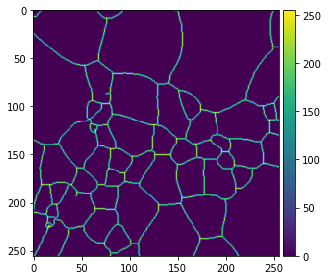

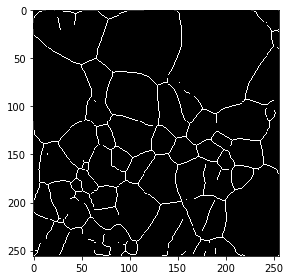

{'x': array([-1.]), 'y': array([1.]), 'chi2': 52921.0, 'avg_chi2': 26460.5}
55402
(260, 260, 3)
1 3 -3 -1
(260, 260, 3)
2 2 -2 -2


/home/jamie/.local/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


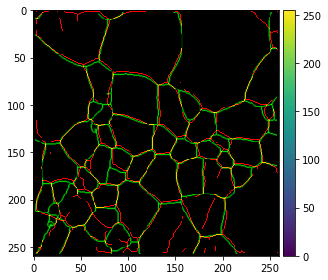

In [ ]:
from chi2test import *
from skimage import io, transform
import numpy as np

traced_n = 13
traced_dir = 'data/test/key/'

ml_img = io.imread('data/test/5_processed.png')
key_img = transform.resize(io.imread('data/test/key/5.png'), ml_img.shape)

if np.min(ml_img) != 0 or np.max(ml_img) != 255:
    ml_img -= np.min(ml_img)
    ml_img = np.round(ml_img * (255 / np.max(ml_img)))
        
if np.min(key_img) != 0 or np.max(key_img) != 255:
    key_img -= np.min(key_img)
    key_img = np.round(key_img * (255 / np.max(key_img)))
    
key_img = 255 - key_img

io.imshow(key_img)
io.show()

io.imshow(ml_img)
io.show()

results = chi2_align(ml_img, key_img)

print(results)

print(find_chi2(ml_img, key_img))

offset_x = int(results["x"])
offset_y = int(results["y"])
fuse_size = np.maximum(key_img.shape, ml_img.shape)
fuse_size[0] += 2 * abs(offset_x) + 2
fuse_size[1] += 2 * abs(offset_y) + 2

def fuse(out, img, offset_x=0, offset_y=0):
    buf_x = out.shape[0] - img.shape[0]
    buf_y = out.shape[1] - img.shape[1]
    img = np.round(img * (255 / np.max(img)))
    x_low = buf_x//2 + offset_x
    y_low = buf_y//2 + offset_y
    x_high = -buf_x//2 + offset_x
    y_high = -buf_y//2 + offset_y
    print(x_low, y_low, x_high, y_high)
    if (x_high > -1):
        x_high = x_low + img.shape[0]
    if (y_high > -1):
        y_high = y_low + img.shape[1]
    out[x_low : x_high, y_low : y_high] = img

fuse_img = np.zeros((fuse_size[0], fuse_size[1], 3), dtype=int)
print(fuse_img.shape)
fuse(fuse_img[:,:,0], ml_img, offset_x, offset_y)
print(fuse_img.shape)
fuse(fuse_img[:,:,1], key_img)

io.imshow(fuse_img)
io.show()


# Intersection Over Union (IOU)
This test should find what percent of the predicted grain boundary (pred) matched the actual hand traced boundary (test)

`iou_test.find_iou(pred, ref)` 
This function finds the mean IOU between `pred` and `ref`. It does this by matching each grain in a traced (`ref`) image with a grain in the corresponding predicted (`pred`) image and calculating the Jaccard similarity index between them. It then takes the mean of all these Jaccard indicies to find the final mean iou of an image.

In [ ]:
from skimage import io, transform
import numpy as np
import iou_test
import importlib, os
importlib.reload(iou_test)

if 'test_n' in locals():
    test_dir = 'data/test/'
    traced_dir = 'data/test/key/'

traced_dir = test_dir + 'key/'
traced_names = np.sort(os.listdir(traced_dir))
traced = np.char.strip(traced_names, '.png')

results = np.array([], dtype=np.float64)

for key in traced:
    ml_img = io.imread(test_dir + key + '_processed.png') / 255
    ml_img = 1 - ml_img
#    ml_img = io.imread(test_dir + key + '_predict.png') / 255
    key_img = transform.resize(io.imread(traced_dir + key + '.png'), ml_img.shape)
    key_img = key_img > 0.9
    
    iou = iou_test.find_iou(ml_img, key_img, verbose=False)
    results = np.append(results, iou)
    print(f' - img {key} \t Mean IOU: {iou}')
    
print(f'\nMean Mean IOU = {np.mean(results)}\nMedian Mean IOU = {np.median(results)}\n\n')
print(f'Max Mean IOU = {np.max(results)}, Min Mean IOU = {np.min(results)}')


 - img 0 	 Mean IOU: 0.6897960320932874
 - img 1 	 Mean IOU: 0.6918237807413546
 - img 10 	 Mean IOU: 0.32937398306008037
 - img 11 	 Mean IOU: 0.4090040275747048
 - img 12 	 Mean IOU: 0.3772879304429595
 - img 13 	 Mean IOU: 0.2836940215242354
 - img 14 	 Mean IOU: 0.263733829255234
 - img 15 	 Mean IOU: 0.3609622702541213
 - img 16 	 Mean IOU: 0.3174240846292632
 - img 17 	 Mean IOU: 0.13929159806323452
 - img 18 	 Mean IOU: 0.29501815187293223
 - img 19 	 Mean IOU: 0.3441311127996548
 - img 2 	 Mean IOU: 0.5405584809756075
 - img 20 	 Mean IOU: 0.3092728479491392
 - img 21 	 Mean IOU: 0.0923450719252461
 - img 22 	 Mean IOU: 0.35390273997218114
 - img 23 	 Mean IOU: 0.32514641024161567
 - img 24 	 Mean IOU: 0.3260055477566883
 - img 25 	 Mean IOU: 0.3415242557556229
 - img 26 	 Mean IOU: 0.2908972545854925
 - img 27 	 Mean IOU: 0.1339033245176248
 - img 28 	 Mean IOU: 0.19717508171493314
 - img 3 	 Mean IOU: 0.4149391995491761
 - img 4 	 Mean IOU: 0.3199635288446575
 - img 5 	 Mean 